### Importing necessary packages

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# Model Architecture

## EncoderDecoder

In [3]:
"""
This is a classic encoder decoder architecture
"""
class EncoderDecoder(nn.Module):
    """
    This class inherits from the nn.module the base class for all neural network modules.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.generator = generator
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        Take in and process masked src and target sequences
        """
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src),src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

## Generator

In [4]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation steps
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    def forward(self, x): # x is (d_model, vocab)
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder

In [8]:
def clones(module, N):
    """
    Produce N identical layers
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
class Encoder(nn.Module):
    """
    Core encoder is a stack of N layers
    """
    def __init__(self, layer, N):
        super(Encoder,self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size) # We will build the class layernorm
    
    def forward(self, x, mask):
        """
        Pass the input (and mask) through each layer in turn
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## LayerNorm

In [6]:
class LayerNorm(nn.Module):
    """
    Employ a residual connection around each of the two sub-layers, 
    followed by layer normalization.
    
    Deeper neural networks are more difficult to train. 
    We present a residual learning framework to ease the training of networks 
    that are substantially deeper than those used previously. 
    We explicitly reformulate the layers as learning residual functions 
    with reference to the layer inputs, instead of learning unreferenced functions. 
    We provide comprehensive empirical evidence showing that these residual networks 
    are easier to optimize, and can gain accuracy from considerably increased depth. 
    On the ImageNet dataset we evaluate residual nets with a depth of up to 
    152 layers---8x deeper than VGG nets but still having lower complexity. 
    An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. 
    This result won the 1st place on the ILSVRC 2015 classification task. 
    We also present analysis on CIFAR-10 with 100 and 1000 layers.
    The depth of representations is of central importance for many visual recognition tasks. 
    Solely due to our extremely deep representations, we obtain a 28% relative improvement 
    on the COCO object detection dataset. 
    Deep residual nets are foundations of our submissions to ILSVRC & COCO 2015 competitions, 
    where we also won the 1st places on the tasks of ImageNet detection, 
    ImageNet localization, COCO detection, and COCO segmentation.
    
    Construct a layernorm module:
    """
    def __init__(self, features, eps=1e-6): # features = layer.size
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
    """
    Output of each sublayer is Layernorm(x + sublayer(x)) where sublaer x is the function
    implemented by the sublayer itself
    """

## SublayerConnection

In [7]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm
    """
    def __init__(self, size, dropout):
        # dropout = the probability of an element to be zeroed
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size
        """
        return x + self.dropout(sublayer(self.norm(x)))

## EncoderLayer

In [10]:
"""
Each layer has two sub layers. First is the multi-head self attention mechanism, and the second
is a simple position wise, fully connected feed-forward network
"""
class EncoderLayer(nn.Module):
    """
    Encoder is made for self -attn and feed forward
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) 
        """
        lambda is basically creating a very short function
        ex:
        raise_to_power = lambda x, y: x ** y
        raise_to_power(2, 3)
        8
        """
        return self.sublayer[1](x, self.feed_forward)

## Decoder

In [ ]:
'''
The decoder is also a stack of N = 6 layers
'''
class Decoder(nn.Module):
    # Generic N layer decoder with masking
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory src_mask, tgt_mask)
        return self.norm(x)

## DecoderLayer 

In [12]:
"""
In addition to the two sublayers in each encoder layer, the decoder inserts a third sublayer
which performs multi head attention over the output of the encoder stack.
Similar to the encoder, residual connections are employed around each of the sub-layers,
followed by layer normalization.
"""
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [15]:
'''
The self attention sublayer is modified in the decoder stack 
to prevent porsitions from attending subsequent positions. This masking
combined with the fact that the output embeddings are offset by one position, ensures
that the prediction for position i, depends only on the known output at position
less than i'''

def subsequent_mask(size):
    "Mask out subsequent positions"
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

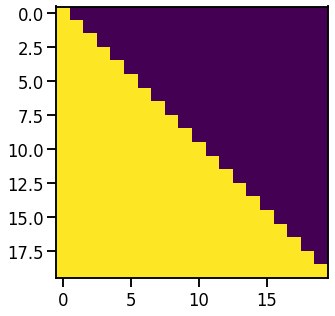

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

## Attention

In [20]:
"""
An attention function can be described as mapping 
a query and a set of key-value pairs to an output.
where the query, keys, values, and output are all vectors
"""

def attention(query, key, value, mask=None, dropout=None):
    "Compute scaled dot product attention"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(d_k)
    if mask is not None:
        score = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

## MultiHeadedAttention 

In [22]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        Take in model size and number of heads
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # we assume d_v amways equals to d_k
        self.d_k = s_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p = dropout)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        # 1. Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
             for l, x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Position-wise Feed-Forward Networks

In [ ]:
"""
each of the layers in our encoder and decoder contains a fully connected feed-forward
network. 
"""
class PositionwiseFeedForward(nn.Module):
    # d_model = 512, d_ff = 2048
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))